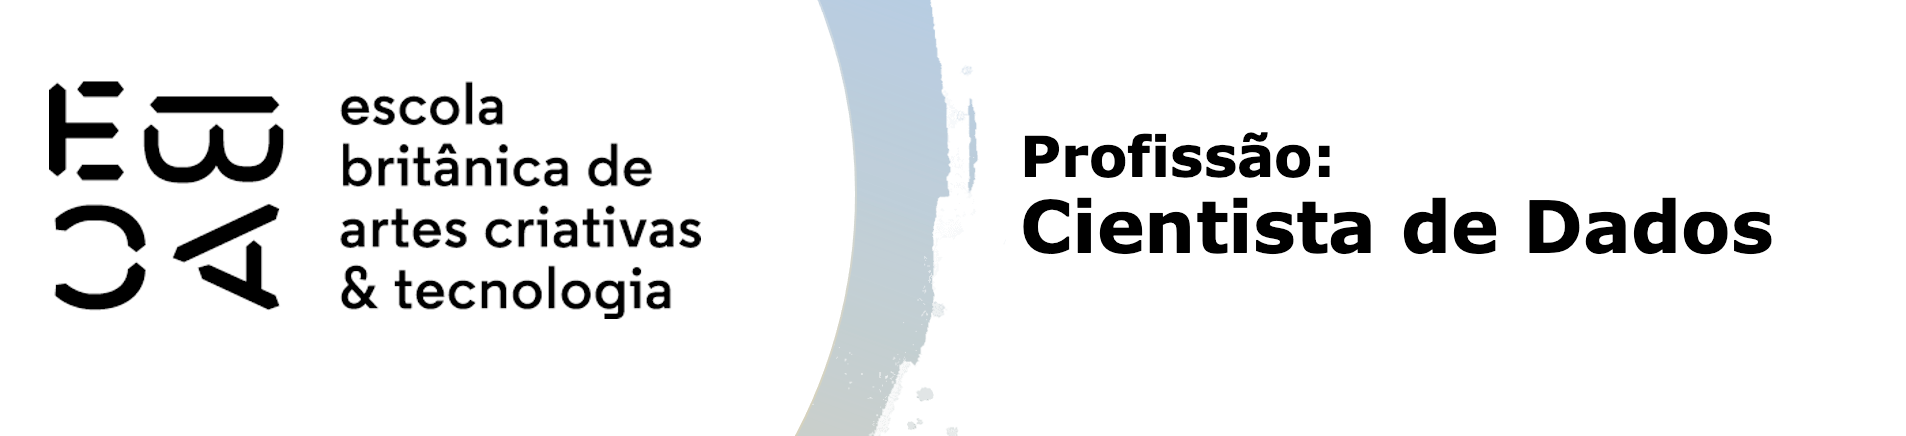

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

### Importando as Bibliotecas 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

import patsy
import statsmodels.api as sm

from scipy.interpolate import interp1d
import warnings;   warnings.filterwarnings("ignore")

from statsmodels.stats.diagnostic import het_breuschpagan


%matplotlib inline

/home/sos/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Carregando os dados

In [2]:
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


### Organizando os dados 

In [3]:
# Identificando valores
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 2015-01-01 to 2016-03-01
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  750000 non-null  int64  
 1   sexo                   750000 non-null  object 
 2   posse_de_veiculo       750000 non-null  object 
 3   posse_de_imovel        750000 non-null  object 
 4   qtd_filhos             750000 non-null  int64  
 5   tipo_renda             750000 non-null  object 
 6   educacao               750000 non-null  object 
 7   estado_civil           750000 non-null  object 
 8   tipo_residencia        750000 non-null  object 
 9   idade                  750000 non-null  int64  
 10  tempo_emprego          624240 non-null  float64
 11  qt_pessoas_residencia  750000 non-null  float64
 12  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 80.1+ MB


In [4]:
# Identificar e contar os valores nulos em cada coluna  
df.isnull().sum()


index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [6]:
# Preenche os valores nulos nas colunas com a mediana 
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median())

# Criar um DataFrame booleano, onde True indica valores nulos e contar os valores 
df.isnull().sum()

index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

### Separando as bases de 'Train' e 'Test'

In [5]:
# Imprimir o menor valor do indice do DataFrame df
print(df.index.min())

# Imprimir o maior valor do indice do DataFrame df
print(df.index.max())

2015-01-01
2016-03-01


In [7]:
# Cria um novo DataFrame df_train a partir de df, incluindo todos os dados até a data '2015-12-01'.
df_train = df[:'2015-12-01']

# Cria um novo DataFrame df_test a partir de df, incluindo todos os dados a partir de '2016-01-01'.
df_test = df['2016-01-01':]

# Cria as variáveis de log_renda 
df_train['log_renda']=np.log(df_train['renda'])
df_test['log_renda']=np.log(df_test['renda'])

## Verifique as suposições do modelo

1. Faça uma análise para avaliar as suposições básicas:

1.1. Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?

1.2. Verifique a independência dos resíduos

1.3. Faça um gráfico dos resíduos versus os valores preditos

1.4. Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo

1.5. Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência

1.6. Avalie se a variância da variável resposta parece ser conforme os valores previstos.


Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

### 1.1. Análises de superposição básicas

In [8]:
# Primeira análise: 


# Utilizando patsy para criar matrizes de design a partir do DataFrame df_train
# A variável dependente é 'log_renda' e as variáveis independentes incluem 'posse_de_imovel' (tratada como categórica),
# 'qtd_filhos', 'idade' e 'tempo_emprego'
formula = 'log_renda ~ C(posse_de_imovel) + qtd_filhos + idade + tempo_emprego'
Y, X = patsy.dmatrices(formula, df_train)


# Ajuste de um modelo de regressão linear usando OLS com regularização Elastic Net
# O parâmetro L1_wt=1 indica que a regularização é puramente Lasso (penalidade L1)
# O parâmetro alpha controla a intensidade da penalidade; aqui configurado para 0.1
# refit=True faz o modelo ser recalculado sem a regularização após a seleção de variáveis
model = sm.OLS(Y, X)
res = model.fit_regularized(method='elastic_net', L1_wt=1, alpha=0.1, refit=True)


# Exibindo o sumário do modelo para avaliar os resultados
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                 1.479e+05
Date:                Mon, 13 May 2024   Prob (F-statistic):               0.00
Time:                        21:58:42   Log-Likelihood:            -8.0413e+05
No. Observations:              600000   AIC:                         1.608e+06
Df Residuals:                  599997   BIC:                         1.608e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [9]:
# Segunda análise:

# Utilizando patsy para criar matrizes de design a partir do DataFrame df_train
# A variável dependente é 'log_renda' e as variáveis independentes incluem 
#'idade' e 'tempo_emprego'
formula = 'log_renda ~ idade + tempo_emprego'
Y, X = patsy.dmatrices(formula, df_train)

# Ajuste de um modelo de regressão linear usando OLS 
model = sm.OLS(Y, X)
res = model.fit()

# Exibindo o sumário do modelo para avaliar os resultados
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                 2.219e+05
Date:                Mon, 13 May 2024   Prob (F-statistic):               0.00
Time:                        21:58:42   Log-Likelihood:            -8.0413e+05
No. Observations:              600000   AIC:                         1.608e+06
Df Residuals:                  599997   BIC:                         1.608e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.3011      0.005   1714.932

In [10]:
# Terceira análise:


# Utilizando patsy para criar matrizes de design a partir do DataFrame df_train
# A variável dependente é 'log_renda' e a variável independente 'tempo_emprego'
formula = 'log_renda ~ tempo_emprego'
Y, X = patsy.dmatrices(formula, df_train)

# Ajuste de um modelo de regressão linear usando OLS 
model = sm.OLS(Y, X)
res = model.fit()

# Exibindo o sumário do modelo para avaliar os resultados
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                 4.438e+05
Date:                Mon, 13 May 2024   Prob (F-statistic):               0.00
Time:                        21:58:43   Log-Likelihood:            -8.0413e+05
No. Observations:              600000   AIC:                         1.608e+06
Df Residuals:                  599998   BIC:                         1.608e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.3112      0.002   4422.433

## 1.2. Verificação da independência dos resíduos

### Comparação dos Três Modelos de Regressão OLS

#### Métricas dos Três Modelos Comparados

| Modelo        | R-squared | Adj. R-squared | F-statistic | Log-Likelihood | AIC       | BIC       | Df Model | Cond. No. |
|---------------|-----------|----------------|-------------|----------------|-----------|-----------|----------|-----------|
| **Modelo 1**  | 0.425     | 0.425          | 1.479e+05   | -8.0413e+05    | 1.608e+06 | 1.608e+06 | 3        | 218       |
| **Modelo 2**  | 0.425     | 0.425          | 2.219e+05   | -8.0413e+05    | 1.608e+06 | 1.608e+06 | 2        | 186       |
| **Modelo 3**  | 0.425     | 0.425          | 4.438e+05   | -8.0413e+05    | 1.608e+06 | 1.608e+06 | 1        | 15.3      |

#### Coeficientes e Estatísticas de Teste para `tempo_emprego` e `Intercept`

| Modelo        | Intercept Coef. | Intercept SE | Intercept t | tempo_emprego Coef. | tempo_emprego SE | tempo_emprego t |
|---------------|-----------------|--------------|-------------|---------------------|------------------|-----------------|
| **Modelo 1**  | 8.3011          | 0.005        | 1714.932    | 0.1296              | 0.000            | 654.103         |
| **Modelo 2**  | 8.3011          | 0.005        | 1714.932    | 0.1296              | 0.000            | 654.103         |
| **Modelo 3**  | 8.3112          | 0.002        | 4422.433    | 0.1297              | 0.000            | 666.184         |

### Análise e Observações

- **Consistência do R-squared**: Todos os modelos mantêm um R-squared e adjusted R-squared de 0.425, indicando que a variável `tempo_emprego` é a principal responsável pela variabilidade explicada em `log_renda`.
- **Melhoria no F-statistic**: Observa-se aumento no F-statistic à medida que variáveis são removidas, indicando melhoria na significância estatística da relação entre as variáveis independentes e a dependente.
- **Alteração no Intercept**: Com a remoção de variáveis, o coeficiente do intercept aumentou e seu erro padrão diminuiu, indicando maior precisão da estimativa.
- **Melhoria na Condição Número (Cond. No.)**: A redução substancial no número de condição sugere melhoria na estabilidade numérica do modelo e redução da multicolinearidade.

### Conclusão

A simplificação do modelo, com a remoção de `C(posse_de_imovel)`, `qtd_filhos` e `idade`, manteve o poder explicativo enquanto melhorou outras métricas importantes. Isso sugere que `tempo_emprego` é suficiente e mais influente para explicar `log_renda`, tornando o modelo mais robusto, interpretável e potencialmente mais generalizável.


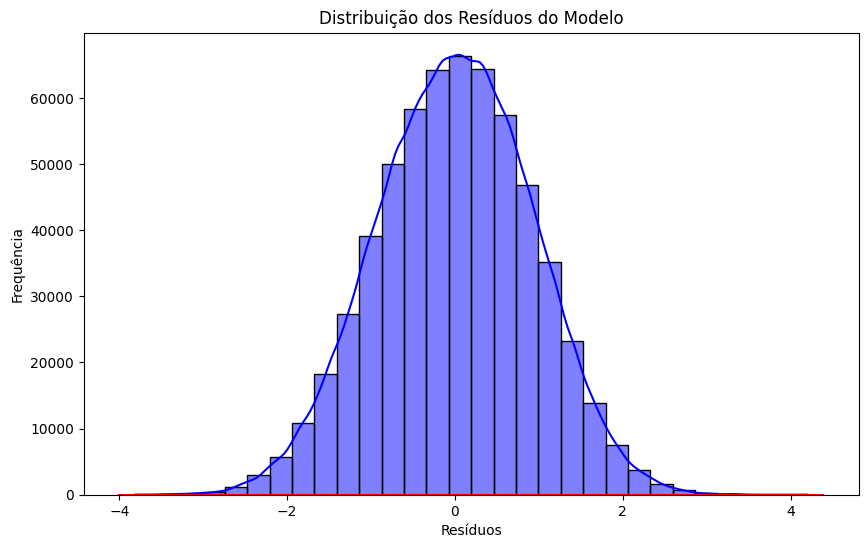

In [11]:
# Configurando o tamanho do gráfico
plt.figure(figsize=(10, 6))  # Ajuste de acordo com sua preferência

# Criando o gráfico de distribuição dos resíduos
sns.histplot(res.resid, kde=True, color='blue', alpha=0.5, bins=30)  # Ajuste o número de bins conforme necessário

# Adicionando uma linha de densidade (KDE)
sns.kdeplot(res.resid, color='red', linewidth=1.5)

# Adicionando título e rótulos aos eixos
plt.title('Distribuição dos Resíduos do Modelo')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')

# Mostrando o gráfico
plt.show()

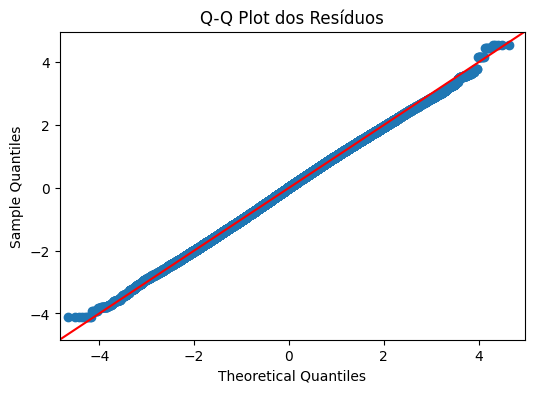

Teste de Shapiro-Wilk: Estatística=0.9995526075363159, p-valor=9.791905467890915e-26
Teste de Kolmogorov-Smirnov: Estatística=0.008936705283586033, p-valor=4.7419861379132236e-42


In [12]:
# Resíduos do modelo
residuals = res.resid

# 1. Gráfico de Probabilidade Normal (Q-Q Plot)
fig, ax = plt.subplots(figsize=(6, 4))
sm.qqplot(residuals, line='45', fit=True, ax=ax)
ax.set_title('Q-Q Plot dos Resíduos')
plt.show()

# 2. Teste de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)
print(f"Teste de Shapiro-Wilk: Estatística={shapiro_test.statistic}, p-valor={shapiro_test.pvalue}")

# 3. Teste de Kolmogorov-Smirnov (comparação com uma distribuição normal)
ks_test = stats.kstest(residuals, 'norm', args=(residuals.mean(), residuals.std()))
print(f"Teste de Kolmogorov-Smirnov: Estatística={ks_test.statistic}, p-valor={ks_test.pvalue}")


### Análise do Q-Q Plot

**Visualização**: O Q-Q Plot mostra que os quantis dos resíduos estão em grande parte alinhados com a linha teórica (indicada em vermelho), o que sugere que os resíduos são aproximadamente normais. No entanto, há pequenos desvios nos extremos da distribuição (particularmente nas caudas), indicando a presença de outliers ou leve excesso de curtose.

### Resultados do Teste de Shapiro-Wilk

- **Estatística de Teste**: `0.9995526075363159`
- **p-valor**: `9.791905467890915e-26`

Apesar da estatística de teste ser muito próxima de 1, indicando uma aproximação à normalidade, o p-valor extremamente pequeno rejeita a hipótese nula de que os resíduos são normalmente distribuídos. Isso sugere que, estatisticamente, há evidências de desvios da normalidade.

### Resultados do Teste de Kolmogorov-Smirnov

- **Estatística de Teste**: `0.008936705283586033`
- **p-valor**: `4.7419861379132236e-42`

O teste de Kolmogorov-Smirnov confirma as conclusões do teste de Shapiro-Wilk. Apesar da estatística de teste ser pequena, indicando apenas um pequeno desvio da normalidade, o p-valor extremamente baixo rejeita a hipótese de normalidade dos resíduos.


### 1.3. Gráfico dos resíduos versus os valores preditos

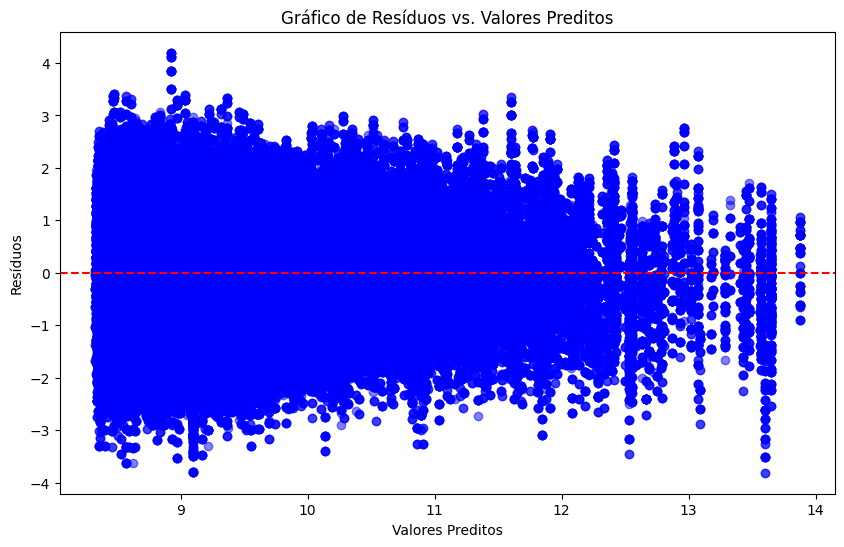

In [13]:
# Calculando os valores preditos
predicted_values = res.fittedvalues

# Calculando os resíduos
residuals = res.resid

# Criando o gráfico
plt.figure(figsize=(10, 6))
plt.scatter(predicted_values, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')  # Linha horizontal em y=0 para referência
plt.title('Gráfico de Resíduos vs. Valores Preditos')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.show()


### 1.4. Avaliação dos padrões dos resíduos versus cada uma das variáveis do modelo

ValueError: array length 600000 does not match index length 750000

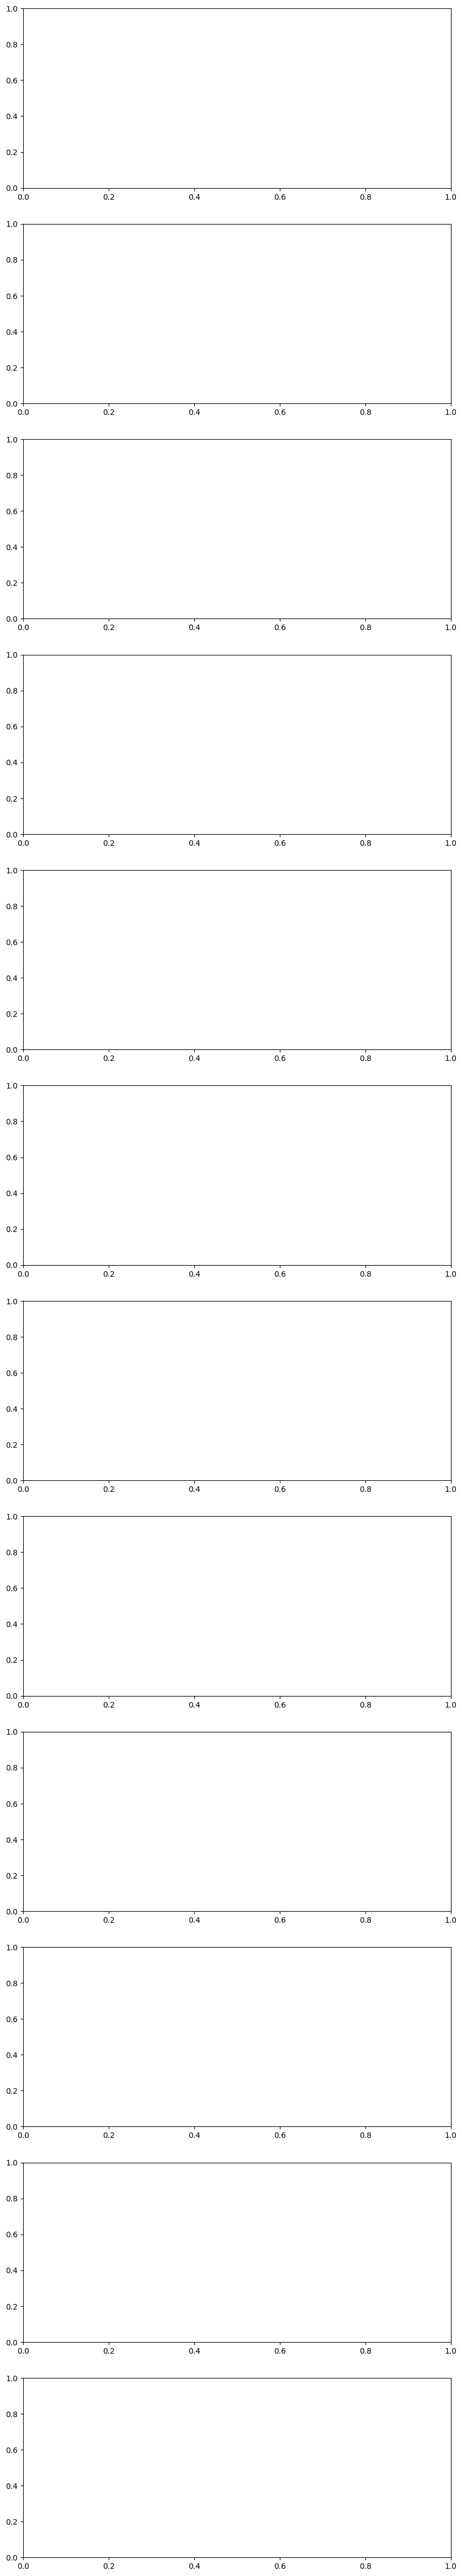

In [14]:
# Lista de variáveis para análise
variables = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda',
             'educacao', 'estado_civil', 'tipo_residencia', 'idade', 'tempo_emprego',
             'qt_pessoas_residencia', 'renda']

# Configurando o layout dos gráficos
fig, axs = plt.subplots(nrows=len(variables), ncols=1, figsize=(10, 5 * len(variables)))

# Loop pelas variáveis para criar gráficos de dispersão dos resíduos
for i, var in enumerate(variables):
    sns.scatterplot(x=df[var], y=res.resid, ax=axs[i], alpha=0.3)
    axs[i].axhline(0, color='red', linestyle='--')
    axs[i].set_title(f'Resíduos vs. {var}')
    axs[i].set_xlabel(var)
    axs[i].set_ylabel('Resíduos')

plt.tight_layout()
plt.show()


### 1.5. Avaliação dos valor médio dos resíduos aparenta ter relação com o mês de referência

In [ ]:
# Acessando a coluna de resíduos no DataFrame
df_train['residuos'] = res.resid

# Criando o gráfico de dispersão
plt.figure(figsize=(12, 6))  # Configura o tamanho do gráfico
sns.scatterplot(x=res.predict(), y=df_train.index)  # Usando o índice como valores de y
plt.title('Gráfico de Dispersão dos Valores Preditos vs. Data de Referência')  # Título do gráfico
plt.xlabel('Valores Preditos')  # Rótulo do eixo x
plt.ylabel('Data de Referência')  # Rótulo do eixo y
plt.xticks(rotation=45)  # Rotaciona os labels do eixo x para melhor visualização, se necessário
plt.grid(True)  # Adiciona grade para melhor visualização
plt.show()  # Exibe o gráfico


### 1.6. Avalie se a variância da variável resposta parece ser conforme os valores previstos.

In [ ]:
# Teste estatístico 

# Teste de Breusch-Pagan
bp_test = het_breuschpagan(residuals, res.model.exog)

# Imprimindo os resultados do teste
labels = ['Estatística de teste', 'p-valor', 'f-valor', 'f p-valor']
for name, value in zip(labels, bp_test):
    print(f"{name}: {value:.4f}")


## Interpretação dos Resultados do Teste de Breusch-Pagan

- **Estatística de teste**: 21.8803
- **p-valor**: 0.0000
- **f-valor**: 21.8810
- **f p-valor**: 0.0000

Esses resultados indicam a presença forte de heteroscedasticidade nos resíduos do modelo de regressão, sugerindo que a variância dos resíduos não é constante.

## Insight

    A heteroscedasticidade pode indicar que variáveis importantes não estão sendo capturadas pelo modelo, ou que as relações modeladas não são adequadas. Revisar as variáveis incluídas e considerar a adição de novas pode ser benéfico.
    
    o modelo atual pode não estar totalmente equipado para lidar com a natureza dos dados, conforme evidenciado pela heteroscedasticidade significativa. Ajustes e melhorias no modelo são recomendados para melhorar o ajuste, a robustez e a confiabilidade das inferências estatísticas derivadas.






## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

In [ ]:
resumo = reg.summary()
resumo.tables[2]

In [ ]:
df_train_short = df_train[:'2015-02-01']
df_train_short.reset_index(inplace=True)
df_train_short.info()

In [ ]:
reg = smf.ols('log_renda ~ tempo_emprego', data=df_train_short).fit()

In [ ]:
%%time

fig = sm.graphics.influence_plot(reg, criterion="cooks")
fig.show()

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.